# Parsing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import gzip, json, csv
# from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Load data
json_path = "./dataset0.json.gz"
labels_path = "./data.info.labelled"

labels = pd.read_csv(labels_path)

# Parse JSON data
def parse_json(path):
    json_data = []
    with gzip.open(path, 'rt') as f:
        for line in f:
            entry = json.loads(line)
            for transcript, position_dict in entry.items():
                for position, sequence_dict in position_dict.items():
                    for sequence, reads in sequence_dict.items():
                        json_data.append({
                            'transcript_id': transcript,
                            'transcript_position': int(position),
                            'sequence': sequence,
                            'reads': reads
                        })

    df = pd.DataFrame(json_data)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'orig_idx'}, inplace=True)
    df.set_index('orig_idx', inplace=True)

    return df

json_df = parse_json(json_path)

# Combine the JSON data with the labels using transcript_id and position
merged_data = json_df.reset_index().merge(labels, on = ['transcript_id', 'transcript_position']).set_index('orig_idx')

print(f"Merged data shape: {merged_data.shape}")

Merged data shape: (121838, 6)


In [ ]:
merged_data

,transcript_id,transcript_position,sequence,reads,gene_id,label
orig_idx,,,,,,
0,ENST00000000233,244,AAGACCA,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0...",ENSG00000004059,0
1,ENST00000000233,261,CAAACTG,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0....",ENSG00000004059,0
2,ENST00000000233,316,GAAACAG,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0...",ENSG00000004059,0
3,ENST00000000233,332,AGAACAT,"[[0.0134, 4.71, 132.0, 0.00447, 4.24, 98.8, 0....",ENSG00000004059,0
4,ENST00000000233,368,AGGACAA,"[[0.015, 6.97, 118.0, 0.0106, 3.04, 123.0, 0.0...",ENSG00000004059,0
...,...,...,...,...,...,...
121833,ENST00000641834,1348,GGGACAT,"[[0.0112, 2.96, 116.0, 0.0093, 3.24, 115.0, 0....",ENSG00000167747,1
121834,ENST00000641834,1429,CTGACAC,"[[0.00697, 4.25, 112.0, 0.00481, 8.67, 119.0, ...",ENSG00000167747,0
121835,ENST00000641834,1531,TGGACAC,"[[0.00996, 3.12, 112.0, 0.00432, 4.5, 115.0, 0...",ENSG00000167747,1


In [ ]:
# reads have 9 elements
# for this example, -1 flanking positions is 243, central position is 244, +1 flanking position is 245
# features:
# (1) length of the direct RNA-Seq signal of the 5-mer nucleotides (dwelling time)
# (2) standard deviation of the direct RNA-Seq signal
# (3) mean of the direct RNA-Seq signal

# so the 9 features for each read:
# dwell time for 243, sd for 243, mean for 243, dwell time for 244, sd for 244, mean for 244, dwell time for 245, sd for 245, mean for 245

# {'transcript': 'ENST00000000233',
#  'position': 244,
#  'sequence': 'AAGACCA',
#  'reads': [[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0.0093, 10.9, 84.1],
#   [0.00631, 2.53, 125.0, 0.00844, 4.67, 126.0, 0.0103, 6.3, 80.9],
#   [0.00465, 3.92, 109.0, 0.0136, 12.0, 124.0, 0.00498, 2.13, 79.6],
# ...]}

# Train-test split (for intermediate)

In [2]:
# split into train (80%) and test (20%) sets, split by gene_id
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)

X = merged_data.drop(columns=['label'])
y = merged_data['label']
groups = merged_data['gene_id']   # For grouping by gene

train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
X_train = X_train.copy()
X_test = X_test.copy()
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Positive samples in train: {sum(y_train)}, Positive samples in test: {sum(y_test)}")

Training set: (98006, 5), Test set: (23832, 5)
Positive samples in train: 4291, Positive samples in test: 1184


# Training data: entire dataset0

In [ ]:
X_train = merged_data.drop(columns=['label'])
y_train = merged_data['label']

In [ ]:
X_test = merged_data.drop(columns=['label'])
y_test = merged_data['label']

# Feature Extraction

In [3]:
def extract_features(reads_list):
    """Extract statistical features from reads"""

    reads_array = np.array(reads_list)  # shape = (n_reads, 9)

    stats = []
    weight_map = {1: 0, 2: 0, 4: 3, 5: 3, 7: 6, 8: 6}  # Map feature indices for sd/mean to their dwell time col for weighting

    for i in range(reads_array.shape[1]):  # for each of the 9 features
        col = reads_array[:, i]
        if i in weight_map:
            w = reads_array[:, weight_map[i]] # corresponding dwell time column
            denom = np.sum(w) # sum of dwell times
            if denom > 0:
                mean_val = np.sum(w * col) / denom # weighted mean
                sd_val = np.sqrt(np.sum(w * (col - mean_val)**2) / denom) # weighted std
                stats.extend([mean_val, sd_val])

        stats.extend([
            np.mean(col),
            np.std(col),
            np.median(col),
            np.min(col),
            np.max(col)
        ])

    # compute diffs between prev-central and next-central
    diffs = {
        "prev": reads_array[:, 3:6] - reads_array[:, 0:3],   # central - previous
        "next": reads_array[:, 6:9] - reads_array[:, 3:6]    # next - central
    }

    # compute average dwell times for weighting
    dwells = {
        "prev": (reads_array[:, 3] + reads_array[:, 0]) / 2,  # avg dwell time between central and previous
        "next": (reads_array[:, 3] + reads_array[:, 6]) / 2    # avg dwell time between central and next
    }

    for key in ["prev", "next"]:
        diff = diffs[key]
        weights = dwells[key]
        denom = np.sum(weights)

        stats.extend([
            np.mean(diff, axis=0).tolist(),  # average per feature type
            np.std(diff, axis=0).tolist(),
            np.median(diff, axis=0).tolist(),
            np.min(diff, axis=0).tolist(),
            np.max(diff, axis=0).tolist()
        ])

        if denom > 0:
            for j in (1,2): # sd diff and mean diff
                w_mean = np.sum(weights * diff[:, j]) / denom
                w_std = np.sqrt(np.sum(weights * (diff[:, j] - w_mean)**2) / denom)
                stats.extend([w_mean, w_std]) # add in weighted mean and std for sd diff and mean diff

    # Flatten lists inside stats
    stats = np.concatenate([np.ravel(s) if isinstance(s, (list, np.ndarray)) else [s] for s in stats])

    return np.array(stats)

def extract_seq_features(df):
    """Extract sequence features from a sequence string."""
    pos = [0,1,2,5,6] # 3 and 4 are A and C from DRACH motif, will not change
    for i in pos:
        df[f'seq_{i}'] = df['sequence'].str[i]
    return df

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

def feature_extraction(df, encoder):
    """Carry out all feature extraction steps on the training/test data."""
    # Extract features from reads
    df = df.copy()
    df['features'] = df['reads'].apply(extract_features)
    n_features = len(df['features'].iloc[0])
    feature_columns = [f'feature_{i}' for i in range(n_features)]
    features_df = pd.DataFrame(df['features'].tolist(), columns=feature_columns, index=df.index)

    # Extract sequence features
    ohe_columns = extract_seq_features(df)
    ohe_columns = encoder.fit_transform(ohe_columns[['seq_0', 'seq_1', 'seq_2', 'seq_5', 'seq_6']])
    ohe_df = pd.DataFrame(ohe_columns, columns=encoder.get_feature_names_out(), index=df.index)

    # Combine all features
    combined_df = pd.concat([features_df, ohe_df], axis=1)
    print(f"Number of features: {len(combined_df.columns)}")
    return combined_df

X_train = feature_extraction(X_train, enc)


Number of features: 111


In [4]:
X_train

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,seq_1_T,seq_2_A,seq_2_G,seq_5_A,seq_5_C,seq_5_T,seq_6_A,seq_6_C,seq_6_G,seq_6_T
orig_idx,,,,,,,,,,,,,,,,,,,,,
0,0.008264,0.005384,0.00697,0.00199,0.0339,4.702505,2.241271,4.223784,1.843025,3.73,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.006609,0.003588,0.00564,0.00199,0.0222,3.354132,2.009640,3.216424,1.689167,2.88,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.007570,0.004444,0.00631,0.00232,0.0299,3.113377,1.368039,2.940541,1.311103,2.65,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.010620,0.006121,0.00902,0.00232,0.0370,6.154831,2.218439,6.476350,2.459317,5.73,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.010701,0.007151,0.00896,0.00199,0.0478,6.810528,3.119258,6.415051,2.743228,6.52,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,0.009594,0.006135,0.00817,0.00232,0.0432,3.540952,1.001850,3.294164,1.104591,3.20,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
121834,0.008393,0.005584,0.00618,0.00232,0.0262,5.240538,2.566369,4.511014,2.275775,3.69,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
121835,0.008161,0.005477,0.00697,0.00232,0.0315,4.149509,1.179391,3.918438,1.200399,3.83,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Save the encoder

In [ ]:
import joblib

joblib.dump(enc, '/content/drive/MyDrive/ohe.pkl')
enc = joblib.load('/content/drive/MyDrive/ohe.pkl')

# Dealing with Imbalanced Classification
# m6A is rare, most positions do not contain m6A

In [ ]:
# Do SMOTE- Synthetic Minority Oversampling Technique + Random Undersampling as a hybrid approach.
# SMOTE reduces imbalance, but can create synthetic noise in feature space — especially when minority samples are near the class boundary.
# Undersampling simplifies the data but risks throwing away valuable negative examples, losing diversity.
# Combined sampling tries to get the best of both worlds:
# First, apply SMOTE to oversample and increase the minority class (so the model “sees” more positive examples),
# Second, apply RandomUnderSampler to undersample and clean / reduce the majority class intelligently to remove redundant or noisy negatives

In [5]:
print(y_train.value_counts()) # y=0 (ABSENCE of m6A) is far more common than y=1 (PRESENCE of m6A)

label
0    93715
1     4291
Name: count, dtype: int64


In [ ]:
y_train

In [6]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

# 1️⃣ Separate numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
#categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns

# Drop the 'features' and 'reads' columns from categorical_cols as they contain numpy arrays and lists
#categorical_cols = categorical_cols.drop(['features', 'reads'], errors='ignore')

# Drop the 'features' column from numeric_cols as well since it's a list of arrays
numeric_cols = numeric_cols.drop(['features'], errors='ignore')


In [7]:
# 3️⃣ Combine numeric + encoded categorical columns
# Ensure consistent indexing before concatenation
X_numeric = X_train[numeric_cols].copy()

# Ensure y_train has matching index
y_train_reset = y_train.copy()

In [8]:
# 4️⃣ Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_numeric, y_train_reset)

# 5️⃣ Convert X_res back to DataFrame
X_train_resampled = pd.DataFrame(X_res, columns=X_numeric.columns)
y_train_resampled = pd.Series(y_res, name='label')


# Resulting balanced dataset
print(X_train_resampled.shape, y_train_resampled.shape)
print(y_train_resampled.value_counts())

(187430, 111) (187430,)
label
0    93715
1    93715
Name: count, dtype: int64


# Apply feature transformations on test data

In [9]:
def test_feature_extraction(test_df, encoder):
    """Carry out all feature extraction steps on the test data."""
    test_df = test_df.copy()
    test_df['features'] = test_df['reads'].apply(extract_features)
    n_features = len(test_df['features'].iloc[0])
    feature_columns = [f'feature_{i}' for i in range(n_features)]

    # Convert features list to separate columns
    features_df = pd.DataFrame(test_df['features'].tolist(), columns=feature_columns, index=test_df.index)

    # Extract sequence features
    ohe_columns = extract_seq_features(test_df)
    ohe_columns = encoder.transform(ohe_columns[['seq_0', 'seq_1', 'seq_2', 'seq_5', 'seq_6']])
    ohe_df = pd.DataFrame(ohe_columns, columns=encoder.get_feature_names_out(), index=test_df.index)

    # Combine all features
    test_df = pd.concat([features_df, ohe_df], axis=1)

    return test_df

# this is only for using full dataset0 as both train and test
# X_test = test_feature_extraction(merged_data.drop(columns=['label']).copy(), enc)

X_test = test_feature_extraction(X_test, enc)

# Model Testing


# Log Reg

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with class weights
lr_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

lr_model.fit(X_train_scaled, y_train_resampled)
y_pred_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_roc_auc = roc_auc_score(y_test, y_pred_lr)
lr_pr_auc = average_precision_score(y_test, y_pred_lr)

print("=== Logistic Regression Performance ===")
print(f"ROC-AUC Score: {lr_roc_auc:.4f}")
print(f"PR-AUC Score: {lr_pr_auc:.4f}")

=== Logistic Regression Performance ===
ROC-AUC Score: 0.9047
PR-AUC Score: 0.4559


# XGBOOST

In [10]:
# After your train/test split code, add:

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV # hyperparameter tuning

# Handle class imbalance
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

# hyperparameter tuning
param_grid = {
    'max_depth': [3, 5],
    # max depth of decision tree
    # higher = more complex model, can overfit
    'learning_rate': [0.1, 0.2],
    # step size for each boosting iteration
    # lower = slower and more stable learning
    'n_estimators': [200, 400],
    # number of trees (boosting rounds)
    # more trees = better fit but slower & risk of overfitting
    'subsample': [0.8, 1.0],
    # fraction of samples per tree
    # <1.0 adds randomness and improves generalisation
    'colsample_bytree': [0.8, 1.0],
    # fraction of features used per tree
    # adds randomness and reduces overfitting
    'min_child_weight': [1, 3],
    # minimum sum of instance weights in a leaf
    # higher = less overfitting, need stronger evidence to make a split
    'gamma': [1, 3],
    # minimum loss reduction to split
    # regularisation- discourages too many small splits
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight * 2],
    # weighting for imbalance
    # adjusts how much positive samples influence the loss
}

model = RandomizedSearchCV(XGBClassifier(eval_metric='logloss', random_state=42, tree_method = 'hist'),
                          param_grid, scoring='average_precision', n_iter=10, cv=2, verbose=3, n_jobs=-1)
model.fit(X_train, y_train)

#model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight,
    #random_state=42,
    #eval_metric='logloss'  # Good for binary classification
#)
#model.fit(X_train, y_train)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [1, 3],
                                        'learning_rate': [0.1, 0.2],
                                        'max_depth': [3, 5],
                                        'min_child_weight': [1, 3],
                                        'n_estimators': [200, 400],
                                        'scale_pos_weight': [21.83989745979958,
                                                             43.67979491959916],
                                        'subsample': [0.8, 1.0]},
                   scoring='average_precision', verbose=3)

=== Model Performance ===
ROC-AUC Score: 0.9218
PR-AUC Score: 0.5057
Number of positive samples in test set: 1184/23832


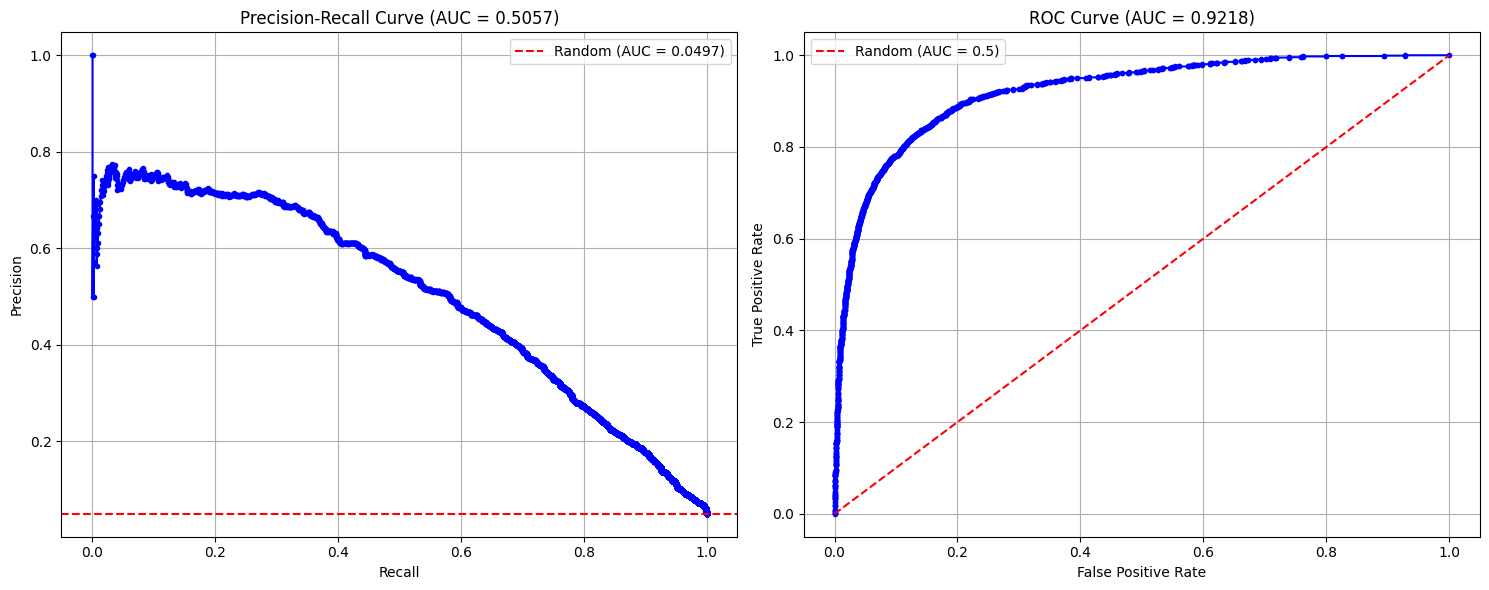

In [11]:
# Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate both metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("=== Model Performance ===")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"PR-AUC Score: {pr_auc:.4f}")
print(f"Number of positive samples in test set: {sum(y_test)}/{len(y_test)}")

# Plot both curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax1.plot(recall, precision, marker='.', color='blue')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
ax1.grid(True)

# Show what random guessing would look like (baseline)
random_baseline = sum(y_test) / len(y_test)
ax1.axhline(y=random_baseline, color='red', linestyle='--',
           label=f'Random (AUC = {random_baseline:.4f})')
ax1.legend()

# ROC Curve (for comparison)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, marker='.', color='blue')
ax2.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random (AUC = 0.5)')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'ROC Curve (AUC = {roc_auc:.4f})')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Random Forest with class weights
rf_model = RandomForestClassifier(
    n_estimators=275,
    max_depth=40,
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]

rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
rf_pr_auc = average_precision_score(y_test, y_pred_rf)

print("=== Random Forest Performance ===")
print(f"ROC-AUC Score: {rf_roc_auc:.4f}")
print(f"PR-AUC Score: {rf_pr_auc:.4f}")

=== Random Forest Performance ===
ROC-AUC Score: 0.9091
PR-AUC Score: 0.4820


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Random Forest with class weights
rf_model = RandomForestClassifier(
    n_estimators=275,
    max_depth=35,
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]

rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
rf_pr_auc = average_precision_score(y_test, y_pred_rf)

print("=== Random Forest Performance ===")
print(f"ROC-AUC Score: {rf_roc_auc:.4f}")
print(f"PR-AUC Score: {rf_pr_auc:.4f}")

=== Random Forest Performance ===
ROC-AUC Score: 0.9078
PR-AUC Score: 0.4807


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Random Forest with class weights
rf_model = RandomForestClassifier(
    n_estimators=275,
    max_depth=40,
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]

rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
rf_pr_auc = average_precision_score(y_test, y_pred_rf)

print("=== Random Forest Performance ===")
print(f"ROC-AUC Score: {rf_roc_auc:.4f}")
print(f"PR-AUC Score: {rf_pr_auc:.4f}")

=== Random Forest Performance ===
ROC-AUC Score: 0.9139
PR-AUC Score: 0.4849


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Random Forest with class weights
rf_model = RandomForestClassifier(
    n_estimators=275,
    max_depth=35,
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]

rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
rf_pr_auc = average_precision_score(y_test, y_pred_rf)

print("=== Random Forest Performance ===")
print(f"ROC-AUC Score: {rf_roc_auc:.4f}")
print(f"PR-AUC Score: {rf_pr_auc:.4f}")

=== Random Forest Performance ===
ROC-AUC Score: 0.9146
PR-AUC Score: 0.4848


# Random forest (final)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Random Forest with class weights
rf_model = RandomForestClassifier(
    n_estimators=275,
    max_depth=40,
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_resampled, y_train_resampled) # using SMOTE
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]

rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
rf_pr_auc = average_precision_score(y_test, y_pred_rf)

print("=== Random Forest Performance ===")
print(f"ROC-AUC Score: {rf_roc_auc:.4f}")
print(f"PR-AUC Score: {rf_pr_auc:.4f}")

=== Random Forest Performance ===
ROC-AUC Score: 0.9139
PR-AUC Score: 0.4849


In [ ]:
import joblib

# Save the Random Forest model to Google Drive
joblib.dump(rf_model, '/content/drive/MyDrive/random_forest_model.pkl')
print("Random Forest model saved successfully to Google Drive!")

In [ ]:
rf_model = joblib.load('/content/drive/MyDrive/random_forest_model.pkl')

# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=42, hidden_layer_sizes=(100, 2), verbose=True, max_iter=60)
# i didn't try any more because it runs quite slowly

clf.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score, average_precision_score
y_mlp_pr = clf.predict_proba(X_test)[:, 1]
mlp_roc_auc = roc_auc_score(y_test, y_mlp_pr)
mlp_pr_auc = average_precision_score(y_test, y_mlp_pr)

print("=== MLP Performance ===")
print(f"ROC-AUC Score: {mlp_roc_auc:.4f}")
print(f"PR-AUC Score: {mlp_pr_auc:.4f}")